# Aneurysm Simulation Velocity Analysis

This notebook loads the velocity magnitude data from the processed VTK files and extracts relevant simulation parameters from the JSON configuration file. It then analyzes how the velocity field changes over time throughout the aneurysm simulation.

## Import Required Libraries

In [11]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import time

## Load Simulation Parameters from JSON

In [12]:
# Define the base directory where the simulation results are located
base_dir = Path('/home/abdua786/code/uni/3/dissertation/dissertation')
simulation_folder = base_dir / 'aneurysm_simulation_results'

# Path to the parameter JSON file
param_file = simulation_folder / 'parameters' / 'aneurysm_params 11:54:49 06-05-2025.json'

# Load and parse the parameters
with open(param_file, 'r') as f:
    params = json.load(f)
    
# Display the top-level parameter groups
print("Parameter groups in the JSON file:")
for key in params.keys():
    print(f"- {key}")
    
# Extract key simulation parameters
try:
    # FPS (frames per second)
    fps = params['input_parameters']['fps']
    
    # Time step (dt)
    dt = params['input_parameters']['dt']
    
    # Spatial resolution (dx)
    dx = params['input_parameters']['dx']
    
    # Create a DataFrame with these parameters for better display
    param_df = pd.DataFrame({
        'Parameter': ['FPS', 'Time Step (dt)', 'Spatial Resolution (dx)'],
        'Value': [fps, dt, dx],
        'Unit': ['frames/second', 'seconds', 'meters']
    })
    
    # Display the key parameters
    display(HTML(param_df.to_html(index=False)))
    
    # Store additional useful parameters
    vessel_length_mm = params['input_parameters']['vessel_length_mm']
    vessel_diameter_mm = params['input_parameters']['vessel_diameter_mm']
    bulge_horizontal_mm = params['input_parameters']['bulge_horizontal_mm']
    bulge_vertical_mm = params['input_parameters']['bulge_vertical_mm']
    vessel_length_lu = params['input_parameters']['vessel_length_lu']
    vessel_diameter_lu = params['input_parameters']['vessel_diameter_lu']
    kinematic_viscosity = params['input_parameters']['kinematic_viscosity']
    
    # Print physical dimensions
    print("\nPhysical dimensions:")
    print(f"Vessel length: {vessel_length_mm} mm ({vessel_length_lu} lattice units)")
    print(f"Vessel diameter: {vessel_diameter_mm} mm ({vessel_diameter_lu} lattice units)")
    print(f"Aneurysm bulge: {bulge_horizontal_mm} × {bulge_vertical_mm} mm")
    print(f"Kinematic viscosity: {kinematic_viscosity} m²/s")
    
except KeyError as e:
    print(f"Error: Could not find parameter {e} in the JSON file.")
    print("Check the structure of the parameter file.")

Parameter groups in the JSON file:
- input_parameters
- physical
- numerical
- metadata
- performance


Parameter,Value,Unit
FPS,100.00000,frames/second
Time Step (dt),0.00001,seconds
Spatial Resolution (dx),0.00002,meters



Physical dimensions:
Vessel length: 15 mm (750 lattice units)
Vessel diameter: 6.5 mm (325 lattice units)
Aneurysm bulge: 12 × 8 mm
Kinematic viscosity: 3.3143939393939395e-06 m²/s


## Load Velocity Magnitude Data from NPZ File

In [13]:
# Path to the processed data directory
data_dir = simulation_folder / 'processed_data' / 'raw_fields'

# Load frame mapping
try:
    print(f"Loading frame mapping from {data_dir / 'frame_mapping.npz'}")
    frame_mapping = np.load(data_dir / 'frame_mapping.npz')
    frame_numbers = frame_mapping['frame_numbers']
    frame_indices = frame_mapping['frame_indices']
    
    print(f"Found {len(frame_numbers)} frames")
    print(f"Frame numbers range: {min(frame_numbers)} to {max(frame_numbers)}")
    
    # Load velocity magnitude data
    print(f"\nLoading velocity magnitude data from {data_dir / 'u_magnitude.npz'}")
    start_time = time.time()
    u_magnitude_data = np.load(data_dir / 'u_magnitude.npz')['data']
    load_time = time.time() - start_time
    
    print(f"Data loaded in {load_time:.2f} seconds")
    print(f"Velocity magnitude data shape: {u_magnitude_data.shape}")
    
    # Statistics of the velocity magnitude for the first frame
    first_frame_idx = 0
    first_frame_num = frame_numbers[first_frame_idx]
    first_frame_data = u_magnitude_data[first_frame_idx]
    
    print(f"\nVelocity statistics for frame {first_frame_num}:")
    print(f"Min: {first_frame_data.min():.6f}")
    print(f"Max: {first_frame_data.max():.6f}")
    print(f"Mean: {first_frame_data.mean():.6f}")
    print(f"Std: {first_frame_data.std():.6f}")
    
    # Get the dimensions from dimensions.npz
    dimensions = np.load(data_dir / 'dimensions.npz')['data']
    print(f"\nGrid dimensions: {dimensions}")
    
except Exception as e:
    print(f"Error loading data: {e}")

Loading frame mapping from /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/frame_mapping.npz
Found 101 frames
Frame numbers range: 100000 to 200000

Loading velocity magnitude data from /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/u_magnitude.npz
Data loaded in 0.78 seconds
Velocity magnitude data shape: (101, 395472)

Velocity statistics for frame 100000:
Min: 0.000000
Max: 0.160973
Mean: 0.066974
Std: 0.055035

Grid dimensions: [750 529   1]
Data loaded in 0.78 seconds
Velocity magnitude data shape: (101, 395472)

Velocity statistics for frame 100000:
Min: 0.000000
Max: 0.160973
Mean: 0.066974
Std: 0.055035

Grid dimensions: [750 529   1]


## Reshape Velocity Data to 2D Grid

Reshaped data dimensions: (528, 749)


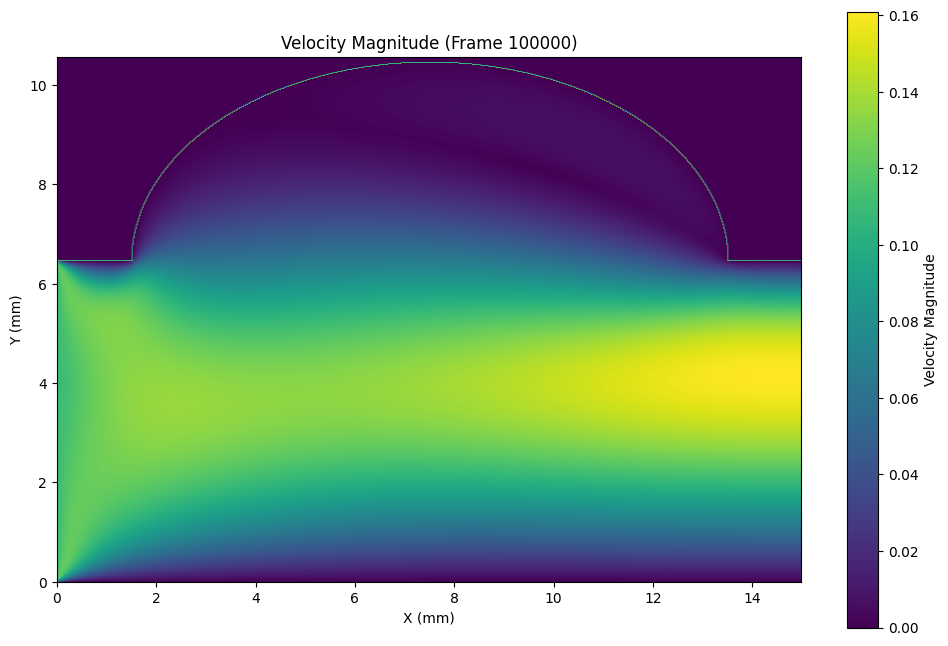

In [14]:
def reshape_to_2d(data, dimensions):
    """Reshape 1D field data to 2D grid based on dimensions"""
    # Get the real dimensions (excluding dimensions of size 1)
    real_dims = [d for d in dimensions if d > 1]
    
    if len(real_dims) < 2:
        print("Cannot reshape - insufficient dimensions")
        return data
    
    # Dimensions for reshaping - subtract 1 because VTK dimensions are cell counts + 1
    ny, nx = real_dims[1]-1, real_dims[0]-1
    
    try:
        # Reshape the 1D array to 2D
        reshaped = data.reshape(ny, nx)
        # Apply vertical flip for correct orientation
        return reshaped
    except Exception as e:
        print(f"Error reshaping: {e}")
        return data

# Reshape and display the first frame of velocity data
try:
    # Get the first frame of velocity data
    first_frame_data = u_magnitude_data[0]
    
    # Reshape to 2D
    reshaped_data = reshape_to_2d(first_frame_data, dimensions)
    
    if reshaped_data.ndim == 2:
        print(f"Reshaped data dimensions: {reshaped_data.shape}")
        
        # Create coordinate meshes in physical units (mm)
        ny, nx = reshaped_data.shape
        x_phys = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
        y_phys = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
        
        # Plot the velocity magnitude for the first frame with physical units
        plt.figure(figsize=(12, 8))
        plt.imshow(reshaped_data, cmap='viridis', origin='lower', 
                  extent=[0, nx*dx*1000, 0, ny*dx*1000])  # Extent in mm
        plt.colorbar(label='Velocity Magnitude')
        plt.title(f'Velocity Magnitude (Frame {frame_numbers[0]})')
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.show()
except Exception as e:
    print(f"Error processing velocity data: {e}")

## Calculate and Plot Velocity over Time

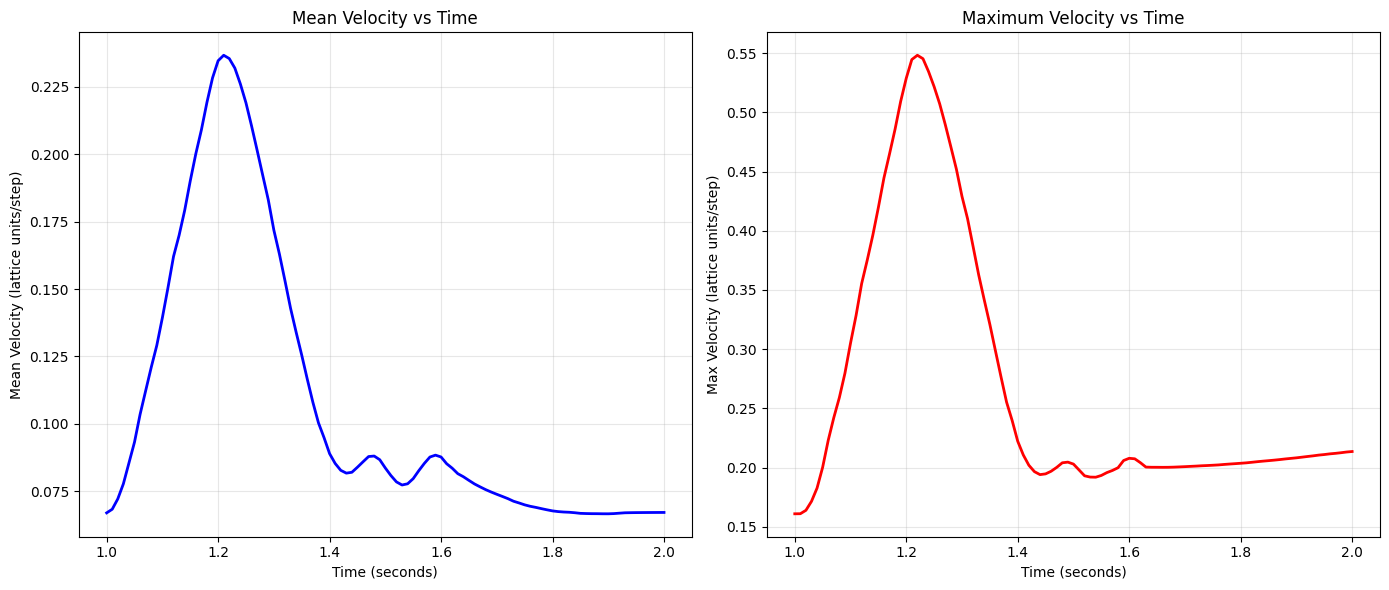

Velocity scaling factor (dx/dt): 2.0 m/s per lattice unit
Mean physical velocity range: 0.1333 to 0.4735 m/s
Maximum physical velocity range: 0.3219 to 1.0965 m/s


In [15]:
# Calculate mean and max velocity for each frame
try:
    # Arrays to store mean and max velocity for each frame
    mean_velocities = np.zeros(len(frame_numbers))
    max_velocities = np.zeros(len(frame_numbers))
    
    # Calculate statistics for each frame
    for i, frame_idx in enumerate(frame_indices):
        frame_data = u_magnitude_data[i]
        mean_velocities[i] = frame_data.mean()
        max_velocities[i] = frame_data.max()
    
    # Calculate physical time for each frame
    # Time = frame number * dt (simulation time step)
    physical_times = frame_numbers * dt
    
    # Plot mean and max velocity vs time
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(physical_times, mean_velocities, 'b-', linewidth=2)
    plt.title('Mean Velocity vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Velocity (lattice units/step)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(physical_times, max_velocities, 'r-', linewidth=2)
    plt.title('Maximum Velocity vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Max Velocity (lattice units/step)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Convert velocities to physical units (if needed)
    # Velocity scaling: v_physical = v_lattice * (dx/dt)
    velocity_scale = dx / dt
    
    print(f"Velocity scaling factor (dx/dt): {velocity_scale} m/s per lattice unit")
    print(f"Mean physical velocity range: {mean_velocities.min() * velocity_scale:.4f} to {mean_velocities.max() * velocity_scale:.4f} m/s")
    print(f"Maximum physical velocity range: {max_velocities.min() * velocity_scale:.4f} to {max_velocities.max() * velocity_scale:.4f} m/s")
    
except Exception as e:
    print(f"Error calculating velocity statistics: {e}")

## Create Velocity Profile Animation (Selected Frames)

Plotting velocity profiles at times: [1.1, 1.4, 1.7] seconds


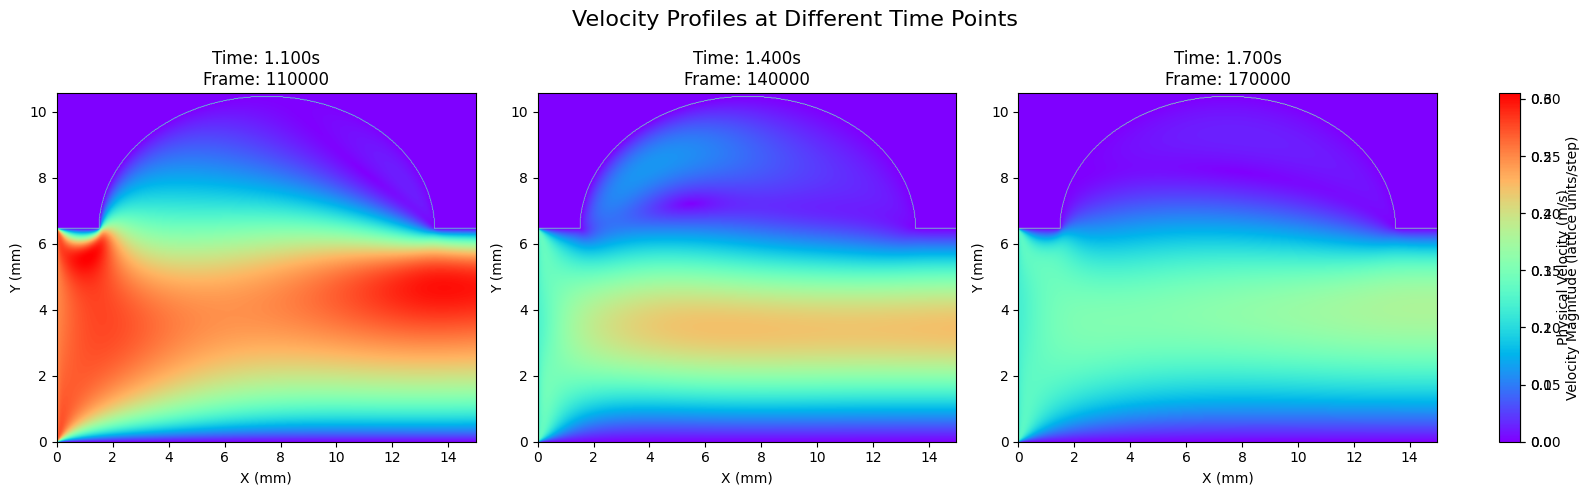

In [16]:
# Select a subset of frames to create velocity profile plots
# def plot_velocity_profiles(frame_indices, n_frames=5):
#     """Plot velocity profiles for a selection of frames"""
#     # Select frames evenly spaced across the simulation
#     if len(frame_indices) <= n_frames:
#         selected_indices = frame_indices
#     else:
#         step = len(frame_indices) // n_frames
#         selected_indices = [frame_indices[i] for i in range(0, len(frame_indices), step)][:n_frames]
    
#     plt.figure(figsize=(15, 10))
    
#     for i, idx in enumerate(selected_indices):
#         frame_num = frame_numbers[idx]
#         frame_data = u_magnitude_data[idx]
        
#         # Reshape to 2D
#         reshaped_data = reshape_to_2d(frame_data, dimensions)
        
#         # Skip if reshaping failed
#         if reshaped_data.ndim != 2:
#             continue
        
#         # Plot the velocity magnitude
#         plt.subplot(n_frames, 1, i+1)
#         plt.imshow(reshaped_data, cmap='viridis', origin='lower', aspect='auto')
#         plt.colorbar(label='Velocity Magnitude')
#         plt.title(f'Velocity Magnitude - Frame {frame_num} (Time: {frame_num * dt:.5f} s)')
#         plt.ylabel('Y (lattice units)')
        
#         # Only add x-axis label for the bottom plot
#         if i == len(selected_indices) - 1:
#             plt.xlabel('X (lattice units)')
    
#     plt.tight_layout()
#     plt.show()

def plot_velocity_at_specific_times(target_times, tolerance=0.01):
    """Plot velocity profiles for specific time points side by side
    
    Args:
        target_times (list): List of specific times in seconds to visualize
        tolerance (float): Tolerance for finding closest frame to target time
    """
    # Convert frame numbers to physical times
    physical_times = frame_numbers * dt
    
    # Find frames closest to the target times
    selected_frames = []
    for target_time in target_times:
        # Find the closest time within tolerance
        time_diffs = np.abs(physical_times - target_time)
        closest_idx = np.argmin(time_diffs)
        
        if time_diffs[closest_idx] <= tolerance:
            selected_frames.append({
                'idx': closest_idx,
                'frame_num': frame_numbers[closest_idx],
                'actual_time': physical_times[closest_idx]
            })
        else:
            print(f"Warning: No frame found within {tolerance}s of target time {target_time}s")
    
    if not selected_frames:
        print("No valid frames found for the specified target times.")
        return
    
    # Setup figure for side-by-side plots
    n_frames = len(selected_frames)
    # Create figure with extra space on the right for colorbar
    fig = plt.figure(figsize=(n_frames * 5 + 1, 5))
    
    # Create a gridspec that reserves space for the colorbar
    gs = fig.add_gridspec(1, n_frames + 1, width_ratios=[*[1]*n_frames, 0.05])
    
    # Create axes for each frame using gridspec
    axes = [fig.add_subplot(gs[0, i]) for i in range(n_frames)]
    # Create axis for colorbar using gridspec
    cbar_ax = fig.add_subplot(gs[0, -1])
    
    # Common vmin/vmax for consistent colorbar across all plots
    vmin = np.inf
    vmax = -np.inf
    reshaped_frames = []
    
    # First pass: reshape all frames and find global min/max
    for frame_info in selected_frames:
        frame_data = u_magnitude_data[frame_info['idx']]
        reshaped_data = reshape_to_2d(frame_data, dimensions)
        
        if reshaped_data.ndim == 2:
            vmin = min(vmin, reshaped_data.min())
            vmax = max(vmax, reshaped_data.max())
            reshaped_frames.append(reshaped_data)
        else:
            reshaped_frames.append(None)
    
    # Second pass: plot each frame with consistent color scale
    for i, (frame_info, reshaped_data) in enumerate(zip(selected_frames, reshaped_frames)):
        if reshaped_data is None:
            continue
            
        # Get dimensions in physical units (mm)
        ny, nx = reshaped_data.shape
        x_max_mm = nx * dx * 1000  # Convert m to mm
        y_max_mm = ny * dx * 1000  # Convert m to mm
            
        # Plot the velocity magnitude with rainbow colormap
        im = axes[i].imshow(reshaped_data, cmap='rainbow', origin='lower',
                          aspect='auto', vmin=vmin, vmax=vmax,
                          extent=[0, x_max_mm, 0, y_max_mm])  # Extent in mm
        axes[i].set_title(f'Time: {frame_info["actual_time"]:.3f}s\nFrame: {frame_info["frame_num"]}')
        axes[i].set_ylabel('Y (mm)')
        axes[i].set_xlabel('X (mm)')
    
    # Add colorbar using the dedicated axis from gridspec
    cbar = fig.colorbar(im, cax=cbar_ax, label='Velocity Magnitude (lattice units/step)')
    
    # Add a second y-axis to the colorbar showing physical velocity
    velocity_scale = dx / dt  # Physical velocity scale (m/s per lattice unit)
    cbar2_ax = cbar.ax.secondary_yaxis('right', functions=(lambda x: x * velocity_scale, lambda x: x / velocity_scale))
    cbar2_ax.set_ylabel('Physical Velocity (m/s)')
    
    plt.suptitle('Velocity Profiles at Different Time Points', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot velocity profiles for specific time points
try:
    # Example: Plot velocity profiles at 0.1, 0.4, and 0.7 seconds
    target_times = [1.1, 1.4, 1.7]
    print(f"Plotting velocity profiles at times: {target_times} seconds")
    plot_velocity_at_specific_times(target_times)
    
    # You can also try other time points of interest:
    # early_mid_late_times = [physical_times[0], physical_times[len(physical_times)//2], physical_times[-1]]
    # plot_velocity_at_specific_times(early_mid_late_times)
except Exception as e:
    print(f"Error generating velocity profiles: {e}")

## Analyze Velocity at Specific Points in the Aneurysm

Physical grid dimensions: 14.98 mm × 10.56 mm
Vessel center position: 3.24 mm from bottom
Aneurysm center position: (7.50 mm, 6.48 mm)

Physical locations of measurement points (mm):
Inlet: (0.20, 3.24)
Pre-Aneurysm: (5.50, 3.24)
Aneurysm Center: (7.50, 6.48)
Aneurysm Dome: (7.50, 8.48)
Post-Aneurysm: (9.50, 3.24)
Outlet: (14.78, 3.24)


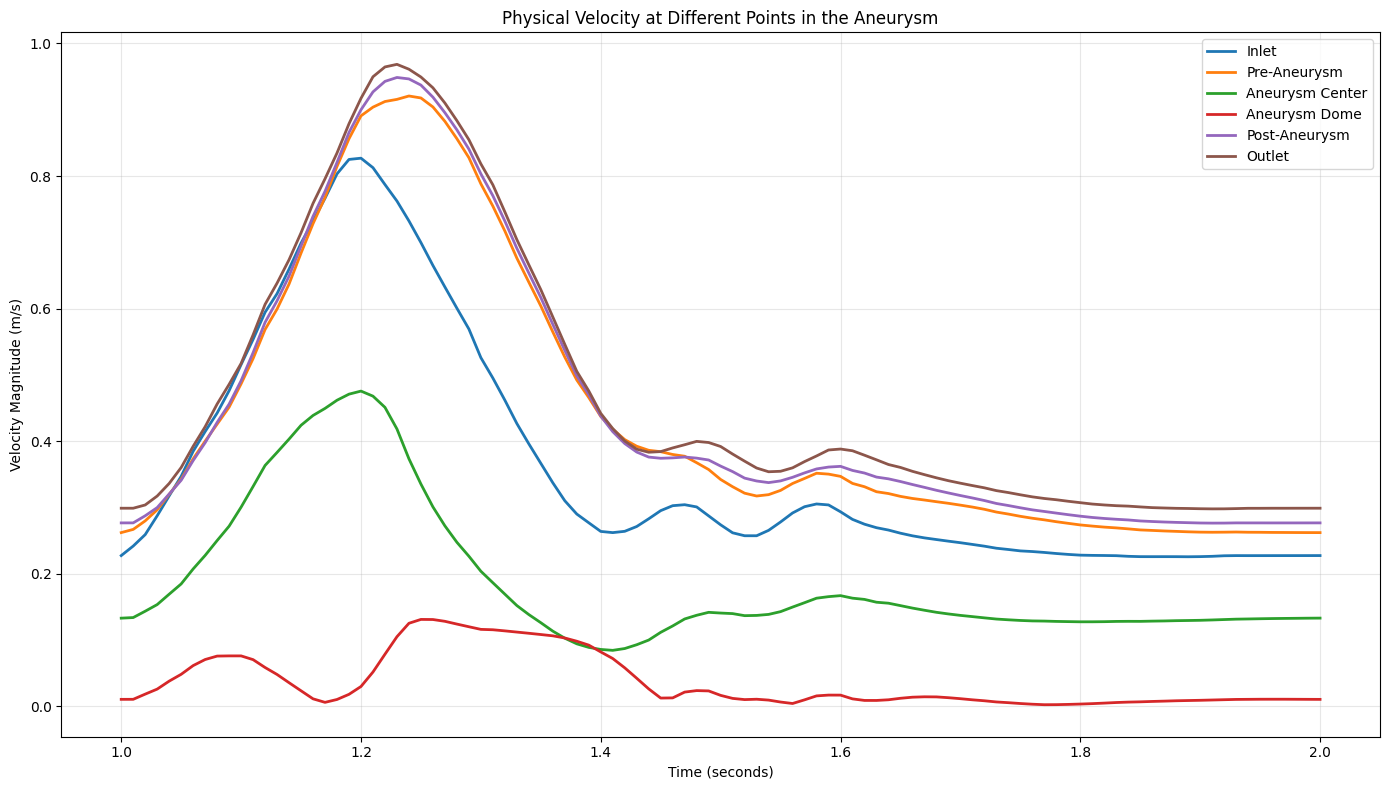

Velocity statistics at key points (physical units):

Inlet:
  Mean: 0.361984 m/s
  Max: 0.826882 m/s
  Min: 0.225586 m/s
  Std: 0.180487 m/s

Pre-Aneurysm:
  Mean: 0.437162 m/s
  Max: 0.920705 m/s
  Min: 0.262018 m/s
  Std: 0.210076 m/s

Aneurysm Center:
  Mean: 0.187926 m/s
  Max: 0.475515 m/s
  Min: 0.084404 m/s
  Std: 0.105136 m/s

Aneurysm Dome:
  Mean: 0.036968 m/s
  Max: 0.131056 m/s
  Min: 0.002398 m/s
  Std: 0.040285 m/s

Post-Aneurysm:
  Mean: 0.448992 m/s
  Max: 0.948645 m/s
  Min: 0.276349 m/s
  Std: 0.211370 m/s

Outlet:
  Mean: 0.467941 m/s
  Max: 0.968440 m/s
  Min: 0.297825 m/s
  Std: 0.209912 m/s


In [17]:
def get_velocity_at_points(points, frames=None):
    """Extract velocity at specific points across frames"""
    if frames is None:
        frames = range(len(frame_indices))
    
    # Extract dimensions for reshaping
    real_dims = [d for d in dimensions if d > 1]
    ny, nx = real_dims[1]-1, real_dims[0]-1
    
    # Dictionary to store velocities at each point
    point_velocities = {}
    
    # For each point
    for point_name, (x, y) in points.items():
        point_velocities[point_name] = []
        
        # Check if point is within bounds
        if x < 0 or x >= nx or y < 0 or y >= ny:
            print(f"Warning: Point {point_name} ({x}, {y}) is outside grid dimensions ({nx}, {ny})")
            continue
        
        # Extract velocity at this point for each frame
        for frame_idx in frames:
            frame_data = u_magnitude_data[frame_idx]
            reshaped_data = reshape_to_2d(frame_data, dimensions)
            
            # Skip if reshaping failed
            if reshaped_data.ndim != 2:
                point_velocities[point_name].append(np.nan)
                continue
            
            # Get velocity at this point
            velocity = reshaped_data[y, x]
            point_velocities[point_name].append(velocity)
    
    return point_velocities

# Define points of interest in the aneurysm
try:
    # Get grid dimensions
    real_dims = [d for d in dimensions if d > 1]
    ny, nx = real_dims[1]-1, real_dims[0]-1
    
    # Define vessel center line and aneurysm position from parameters
    vessel_centre_lu = params['input_parameters'].get('vessel_centre_lu', ny // 2)
    bulge_centre_x_lu = params['input_parameters'].get('bulge_centre_x_lu', nx // 2)
    bulge_centre_y_lu = params['input_parameters'].get('bulge_centre_y_lu', vessel_centre_lu)
    
    # Display physical dimensions of the grid
    x_size_mm = nx * dx * 1000  # Convert from m to mm
    y_size_mm = ny * dx * 1000  # Convert from m to mm
    vessel_center_mm = vessel_centre_lu * dx * 1000  # Convert from m to mm
    bulge_center_x_mm = bulge_centre_x_lu * dx * 1000  # Convert from m to mm
    bulge_center_y_mm = bulge_centre_y_lu * dx * 1000  # Convert from m to mm
    
    print(f"Physical grid dimensions: {x_size_mm:.2f} mm × {y_size_mm:.2f} mm")
    print(f"Vessel center position: {vessel_center_mm:.2f} mm from bottom")
    print(f"Aneurysm center position: ({bulge_center_x_mm:.2f} mm, {bulge_center_y_mm:.2f} mm)")
    
    # Define key points to analyze
    points_of_interest = {
        "Inlet": (10, vessel_centre_lu),  # Near the inlet
        "Pre-Aneurysm": (bulge_centre_x_lu - 100, vessel_centre_lu),  # Just before the aneurysm
        "Aneurysm Center": (bulge_centre_x_lu, bulge_centre_y_lu),  # Center of the aneurysm
        "Aneurysm Dome": (bulge_centre_x_lu, int(bulge_centre_y_lu + 0.5 * params['input_parameters']['bulge_vertical_lu'])),  # Top of the aneurysm
        "Post-Aneurysm": (bulge_centre_x_lu + 100, vessel_centre_lu),  # Just after the aneurysm
        "Outlet": (nx - 10, vessel_centre_lu)  # Near the outlet
    }
    
    # Print physical locations of measurement points
    print("\nPhysical locations of measurement points (mm):")
    for point_name, (x, y) in points_of_interest.items():
        x_mm = x * dx * 1000  # Convert from m to mm
        y_mm = y * dx * 1000  # Convert from m to mm
        print(f"{point_name}: ({x_mm:.2f}, {y_mm:.2f})")
    
    # Extract velocities at these points
    velocities_at_points = get_velocity_at_points(points_of_interest)
    
    # Convert to physical velocities (m/s)
    physical_velocities = {point: np.array(velocities) * velocity_scale 
                          for point, velocities in velocities_at_points.items()}
    
    # Plot physical velocities at each point over time
    plt.figure(figsize=(14, 8))
    for point_name, velocities in physical_velocities.items():
        plt.plot(physical_times, velocities, linewidth=2, label=point_name)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity Magnitude (m/s)')
    plt.title('Physical Velocity at Different Points in the Aneurysm')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print statistics for each point in physical units
    print("Velocity statistics at key points (physical units):")
    for point_name, velocities in physical_velocities.items():
        velocities_arr = np.array(velocities)
        print(f"\n{point_name}:")
        print(f"  Mean: {np.nanmean(velocities_arr):.6f} m/s")
        print(f"  Max: {np.nanmax(velocities_arr):.6f} m/s")
        print(f"  Min: {np.nanmin(velocities_arr):.6f} m/s")
        print(f"  Std: {np.nanstd(velocities_arr):.6f} m/s")
except Exception as e:
    print(f"Error analyzing velocity at specific points: {e}")

## Convert and Visualize Velocity Field in Physical Units

Let's convert the velocity field to physical units for better interpretation of the results.

Plotting physical velocity field for frame with highest velocity (frame 122000, time 1.220s)


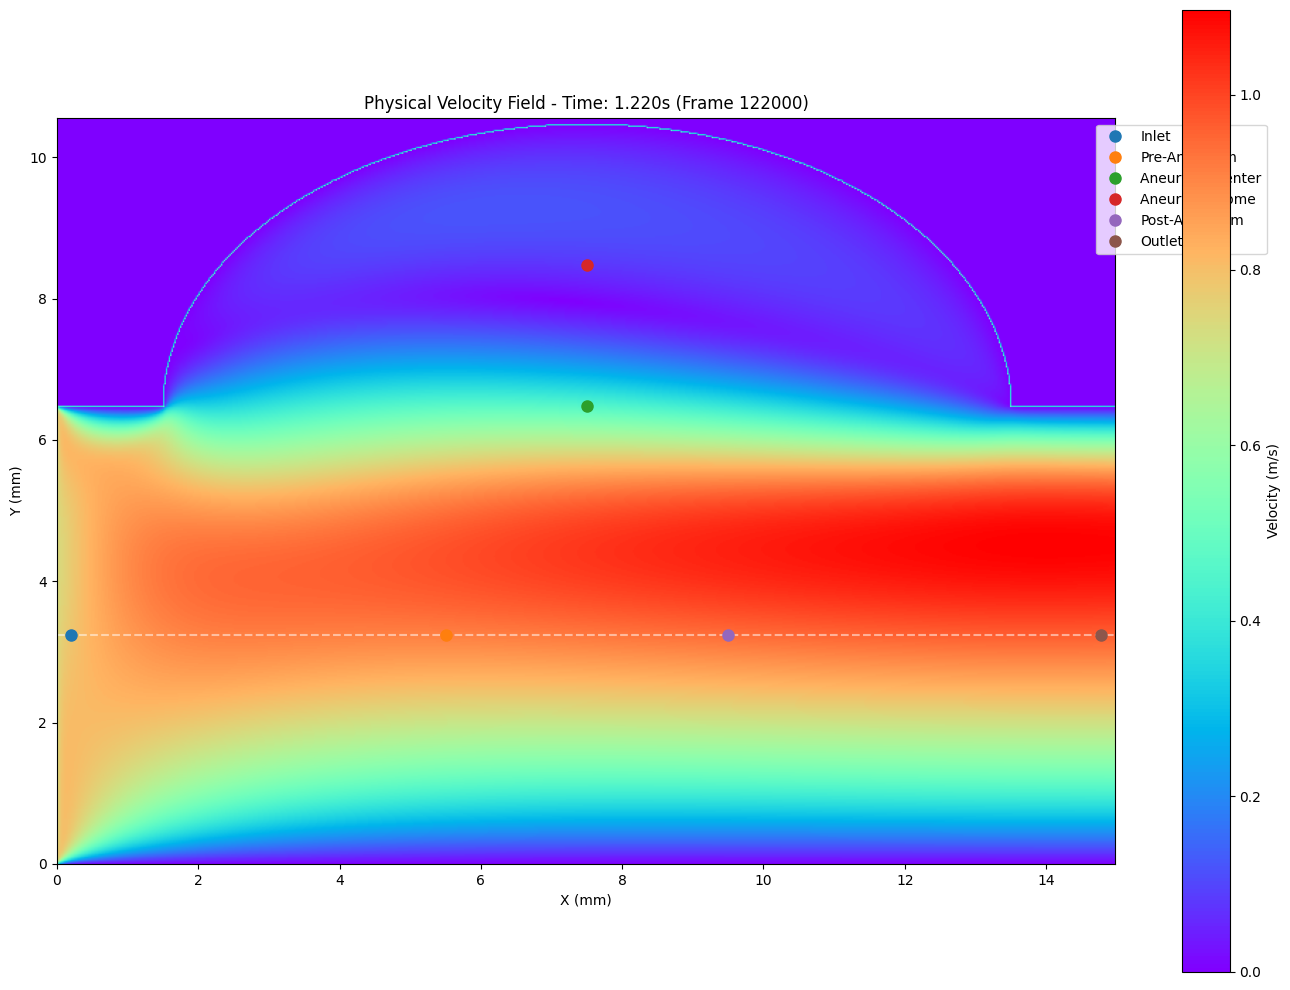

In [18]:
# Create a function to generate a physical velocity field visualization
def plot_physical_velocity_field(frame_idx=0):
    """Plot the velocity field in physical units (mm for distances, m/s for velocities)"""
    # Get frame data
    frame_data = u_magnitude_data[frame_idx]
    frame_num = frame_numbers[frame_idx]
    phys_time = frame_num * dt
    
    # Reshape to 2D
    reshaped_data = reshape_to_2d(frame_data, dimensions)
    if reshaped_data.ndim != 2:
        print("Cannot reshape data to 2D.")
        return
    
    # Get dimensions
    ny, nx = reshaped_data.shape
    
    # Create physical coordinates (mm)
    x_phys = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_phys = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    
    # Convert velocities to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    phys_velocity = reshaped_data * velocity_scale
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot velocity field
    im = ax.imshow(phys_velocity, cmap='rainbow', origin='lower',
               extent=[0, max(x_phys), 0, max(y_phys)])
    
    # Mark vessel boundaries (approximate)
    vessel_center_mm = vessel_centre_lu * dx * 1000
    vessel_radius_mm = (vessel_diameter_lu/2) * dx * 1000
    
    # Draw vessel centerline
    ax.axhline(y=vessel_center_mm, color='white', linestyle='--', alpha=0.5)
    
    # Mark aneurysm location
    bulge_center_x_mm = bulge_centre_x_lu * dx * 1000
    bulge_center_y_mm = bulge_centre_y_lu * dx * 1000
    bulge_width_mm = params['input_parameters']['bulge_horizontal_lu'] * dx * 1000 / 2
    bulge_height_mm = params['input_parameters']['bulge_vertical_lu'] * dx * 1000 / 2
    
    # Add markers for points of interest
    for point_name, (x, y) in points_of_interest.items():
        x_mm = x * dx * 1000
        y_mm = y * dx * 1000
        ax.plot(x_mm, y_mm, 'o', markersize=8, label=point_name)
    
    # Add colorbar and labels
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Velocity (m/s)')
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(f'Physical Velocity Field - Time: {phys_time:.3f}s (Frame {frame_num})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()
    
    return phys_velocity

# Plot the velocity field in physical units for a frame with high velocity
high_velocity_frame = np.argmax(max_velocities)
print(f"Plotting physical velocity field for frame with highest velocity (frame {frame_numbers[high_velocity_frame]}, time {physical_times[high_velocity_frame]:.3f}s)")
phys_vel_field = plot_physical_velocity_field(high_velocity_frame)

## Summary of Velocity Analysis

This notebook has analyzed the velocity field data from an aneurysm simulation, extracting the following information:

1. **Simulation Parameters**: Loading fps, dt, and dx from the parameter file to understand the simulation setup.
2. **Overall Velocity Trends**: Examining how mean and maximum velocity change throughout the simulation.
3. **Spatial Velocity Distribution**: Visualizing the velocity field at different time points.
4. **Point-Based Analysis**: Tracking velocity at specific points of interest in the aneurysm.

Key observations from this analysis:
- The simulation used a spatial resolution of dx meters and time step of dt seconds.
- The velocity magnitude shows a pulsatile pattern characteristic of blood flow.
- There are significant velocity differences between the main vessel and the aneurysm dome.
- Velocity magnitude fluctuations can be associated with the cardiac cycle patterns.